In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import GRU, Dense

## Bitcoin

In [2]:
df = pd.read_csv('Bitcoin Historical Data.csv')
# df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
# df.info()

In [8]:
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
df1 = df1.str.replace(',', '').astype(float)
df1

0          34.5
1          34.3
2          34.5
3          36.2
4          40.3
         ...   
4106    68366.0
4107    67635.8
4108    68354.7
4109    67530.1
4110    67760.8
Name: Price, Length: 4111, dtype: float64

In [9]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [10]:
# 4. Chia train và test theo tỷ lệ 60-40
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [11]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [13]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0455
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0023
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 9.0102e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 5.5990e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 3.4093e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 3.2282e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 2.8537e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 2.5330e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 2.4114e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 2.3175e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 2.2602e-04
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 2.5284e-04
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 3.1621e-04
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 2.3905e-0

In [16]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [17]:
# 12. Đánh giá độ chính xác thuật toán
# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

# MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)


Testing RMSE: 1130.5899319809573
Testing MAPE: 2.079349529812775
Testing MAE: 700.2716648091241


In [18]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1, 1)

temp_input = list(x_input[0])
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = time_step
i = 0

while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

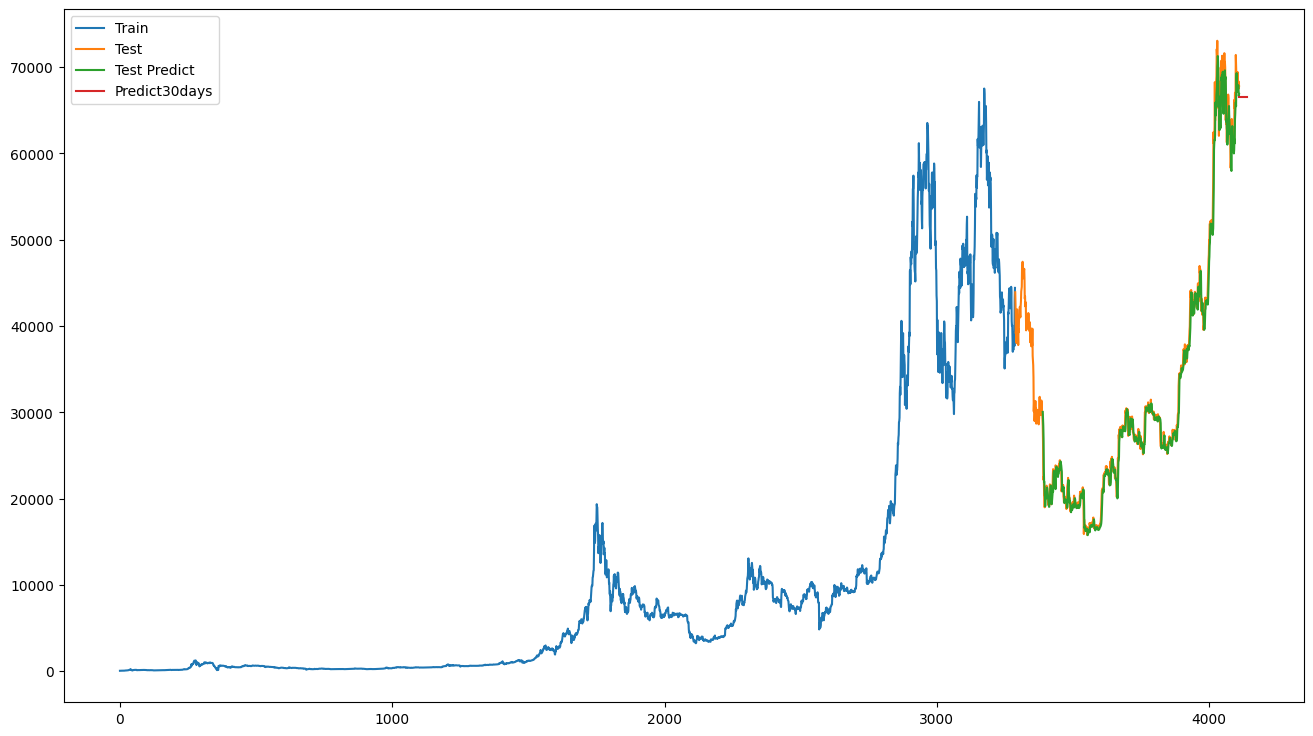

In [19]:
# 14. Vẽ hình
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

predict_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output))

plt.legend(['Train', 'Test', 'Test Predict', 'Predict30days'])
plt.show()

## Nasdaq

In [20]:
df = pd.read_csv('NASDAQ Composite Historical Data.csv')
# df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
# df.info()

In [21]:
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
df1 = df1.str.replace(',', '').astype(float)
df1

0        3169.74
1        3182.03
2        3224.13
3        3222.37
4        3232.09
          ...   
2828    16920.79
2829    17019.88
2830    16920.58
2831    16737.08
2832    16735.02
Name: Price, Length: 2833, dtype: float64

In [23]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [24]:
# 4. Chia train và test theo tỷ lệ 60-40
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [25]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [26]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [27]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [28]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0691
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0016
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1.6479e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 1.2221e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1.0213e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 1.0723e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1.0672e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 9.5531e-05
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 9.8168e-05
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 1.0112e-04
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 8.9294e-05
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 9.2027e-05
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 9.3398e-05
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 8.9704e-05
Epoch 15/

In [30]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [31]:
# 12. Đánh giá độ chính xác thuật toán
# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

# MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)


Testing RMSE: 177.38105136298324
Testing MAPE: 1.094477393784388
Testing MAE: 141.52804721030046


In [32]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1, 1)

temp_input = list(x_input[0])
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = time_step
i = 0

while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

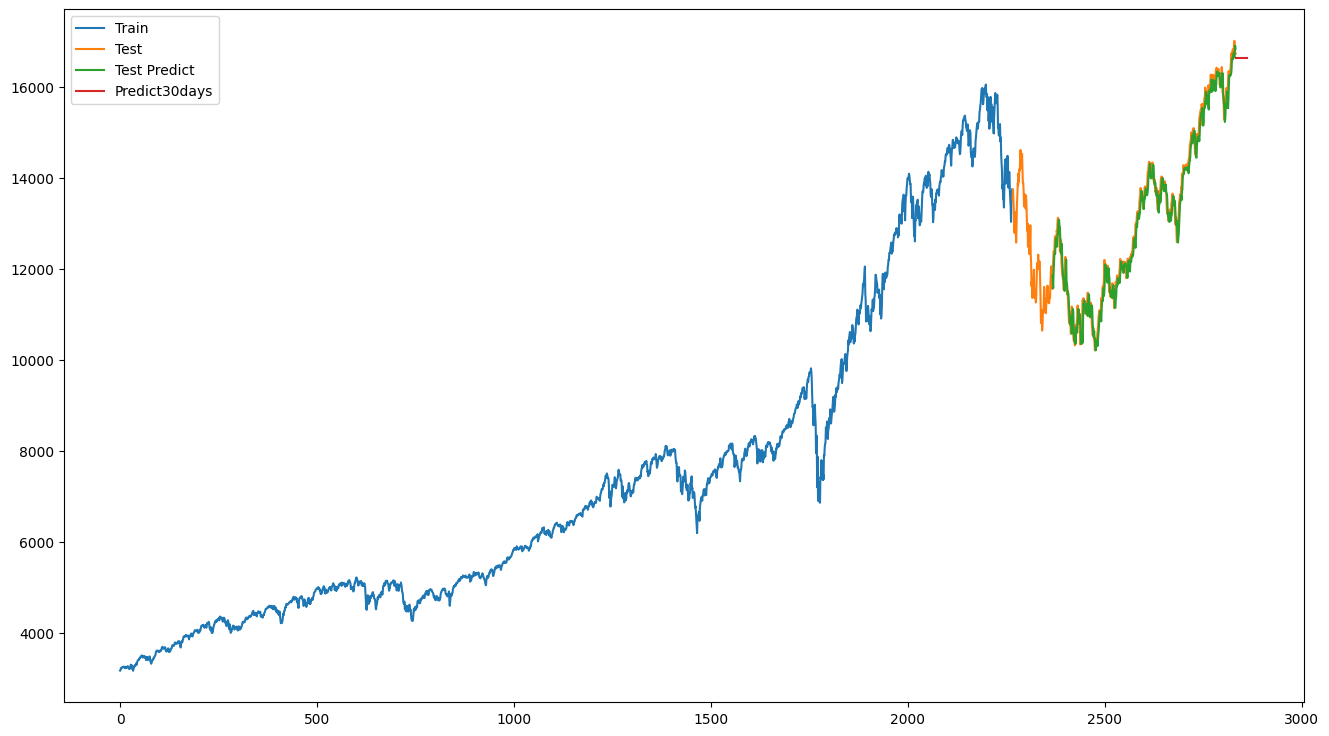

In [33]:
# 14. Vẽ hình
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

predict_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output))

plt.legend(['Train', 'Test', 'Test Predict', 'Predict30days'])
plt.show()

## USD

In [34]:
df = pd.read_csv('US Dollar Index Futures Historical Data.csv')
# df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
# df.info()

In [36]:
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
df1

0        82.358
1        82.255
2        82.147
3        82.507
4        82.123
         ...   
2902    104.638
2903    104.539
2904    105.034
2905    104.658
2906    104.627
Name: Price, Length: 2907, dtype: float64

In [37]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [38]:
# 4. Chia train và test theo tỷ lệ 60-40
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [39]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [40]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [41]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [42]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0506
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0028
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 7.3018e-04
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 2.6670e-04
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 2.5774e-04
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 2.1448e-04
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 2.3287e-04
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 2.0943e-04
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 2.3098e-04
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 1.9845e-04
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 1.9744e-04
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 2.0317e-04
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 1.7360e-04
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 1.9550e-04
Epoch 15/

In [44]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [45]:
# 12. Đánh giá độ chính xác thuật toán
# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

# MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)


Testing RMSE: 0.5272424728278275
Testing MAPE: 0.36504518172887296
Testing MAE: 0.3845785853649622


In [46]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1, 1)

temp_input = list(x_input[0])
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = time_step
i = 0

while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

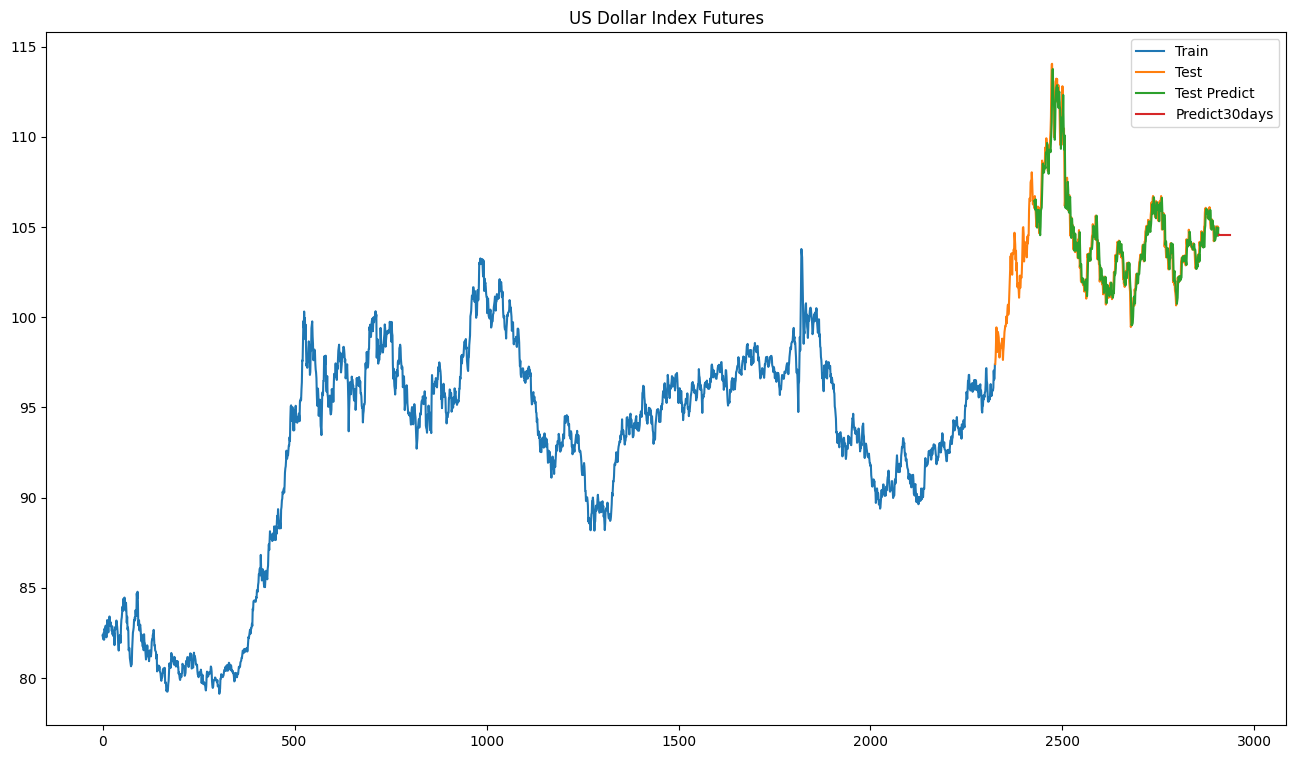

In [48]:
# 14. Vẽ hình
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

predict_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output))

plt.legend(['Train', 'Test', 'Test Predict', 'Predict30days'])
plt.title('US Dollar Index Futures')
plt.show()